In [1]:
# Add graphviz to path
import os

os.environ["PATH"] = os.environ["PATH"] + ":/opt/homebrew/bin"

# Imports
from datetime import date
from pprint import pprint

import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
import seaborn as sns
from matplotlib import ticker

from vaxflux.covariates import (
    CovariateCategories,
    GaussianRandomWalkCovariate,
    PooledCovariate,
)
from vaxflux.curves import LogisticIncidenceCurve
from vaxflux.dates import SeasonRange, daily_date_ranges
from vaxflux.uptake import SeasonalUptakeModel

In [2]:
logistic_curve = LogisticIncidenceCurve()
logistic_curve

In [3]:
logistic_curve.parameters

('m', 'r', 's')

In [4]:
season_ranges = [
    SeasonRange(
        season="2022/2023", start_date=date(2022, 9, 5), end_date=date(2023, 4, 30)
    ),
    SeasonRange(
        season="2023/2024", start_date=date(2023, 9, 4), end_date=date(2024, 4, 28)
    ),
]
date_ranges = daily_date_ranges(season_ranges, range_days=6)

In [5]:
model = SeasonalUptakeModel(
    logistic_curve,
    [
        PooledCovariate(
            parameter="m",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": 0.5, "sigma": 0.1},
        ),
        GaussianRandomWalkCovariate(
            parameter="m",
            covariate="sex",
            init_mu=0.15,
            mu=0.0,
            sigma=0.015,
        ),
        GaussianRandomWalkCovariate(
            parameter="m",
            covariate="age",
            init_mu=[0.1, 0.2],
            mu=[0.0, 0.0],
            sigma=[0.015, 0.015],
        ),
        PooledCovariate(
            parameter="r",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": -3.25, "sigma": 0.25},
        ),
        PooledCovariate(
            parameter="s",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": 45.0, "sigma": 2.0},
        ),
    ],
    covariate_categories=[
        CovariateCategories(covariate="sex", categories=("female", "male")),
        CovariateCategories(covariate="age", categories=("youth", "adult", "senior")),
    ],
    season_ranges=season_ranges,
    date_ranges=date_ranges,
    epsilon=0.0005,
    name="Test Model",
)
model

In [6]:
model.coordinates().get("season_by_category")

['season_2022_2023_sex_female_age_youth',
 'season_2022_2023_sex_female_age_adult',
 'season_2022_2023_sex_female_age_senior',
 'season_2022_2023_sex_male_age_youth',
 'season_2022_2023_sex_male_age_adult',
 'season_2022_2023_sex_male_age_senior',
 'season_2023_2024_sex_female_age_youth',
 'season_2023_2024_sex_female_age_adult',
 'season_2023_2024_sex_female_age_senior',
 'season_2023_2024_sex_male_age_youth',
 'season_2023_2024_sex_male_age_adult',
 'season_2023_2024_sex_male_age_senior']

In [7]:
pprint(model.coordinates())

{'covariate_age_categories': ['youth', 'adult', 'senior'],
 'covariate_age_categories_limited': ['adult', 'senior'],
 'covariate_names': ['sex', 'age'],
 'covariate_sex_categories': ['female', 'male'],
 'covariate_sex_categories_limited': ['male'],
 'parameters': ['m', 'r', 's'],
 'season': ['2022/2023', '2023/2024'],
 'season_2022_2023_dates': ['2022-09-05',
                            '2022-09-06',
                            '2022-09-07',
                            '2022-09-08',
                            '2022-09-09',
                            '2022-09-10',
                            '2022-09-11',
                            '2022-09-12',
                            '2022-09-13',
                            '2022-09-14',
                            '2022-09-15',
                            '2022-09-16',
                            '2022-09-17',
                            '2022-09-18',
                            '2022-09-19',
                            '2022-09-20',
        

In [8]:
model.build(debug=True)

INFO: Using 68 date ranges for the uptake model.
ERROR: No observations were provided, will not be able to calibrate model only sample from prior.
INFO: Added season 2022/2023 to the model with 238 days.
INFO: Added season 2023/2024 to the model with 238 days.
INFO: Added covariate MSeason to the model.
INFO: Added covariate MSex to the model.
INFO: Added covariate MAge to the model.
INFO: Added covariate RSeason to the model.
INFO: Added covariate SSeason to the model.
INFO: Added summed parameter MSeason20222023SexFemaleAgeYouth to the model.
INFO: Added summed parameter RSeason20222023SexFemaleAgeYouth to the model.
INFO: Added summed parameter SSeason20222023SexFemaleAgeYouth to the model.
INFO: Added summed parameter MSeason20232024SexFemaleAgeYouth to the model.
INFO: Added summed parameter RSeason20232024SexFemaleAgeYouth to the model.
INFO: Added summed parameter SSeason20232024SexFemaleAgeYouth to the model.
INFO: Added summed parameter MSeason20222023SexFemaleAgeAdult to the 

In [9]:
model._model

                                                MSeason ~ Normal(0.5, 0.1)
                                                   MSex ~ RandomWalk(Normal(0.15, 0.015), Normal(0, 0.015), f())
                                         MAgePackedChol ~ _lkjcholeskycov(2, 1, Exponential(f()))
                                                   MAge ~ RandomWalk(MultivariateNormal(f(MAgePackedChol), f(MAgePackedChol)), MultivariateNormal(f(MAgePackedChol), f(MAgePackedChol)), f(<multivariate_normal>))
                                                RSeason ~ Normal(-3.25, 0.25)
                                                SSeason ~ Normal(45, 2)
                                                epsilon ~ Exponential(f())
                     Incidence20222023SexFemaleAgeYouth ~ Gamma(f(epsilon, MSex, MSeason, SSeason, RSeason), f(epsilon, MSex, MSeason, SSeason, RSeason))
                     Incidence20232024SexFemaleAgeYouth ~ Gamma(f(epsilon, MSex, MSeason, SSeason, RSeason), f(epsilon, MSex

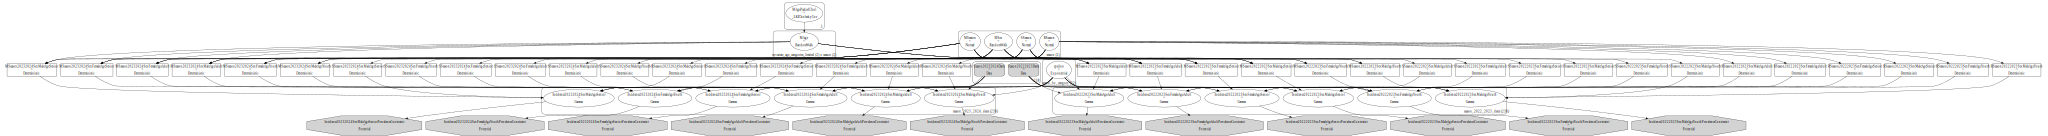

In [10]:
pm.model_to_graphviz(model._model)

In [11]:
prior = model.sample_prior()
prior

/Users/twillard/Desktop/GitHub/ACCIDDA/vaxflux/src/vaxflux/uptake.py:417: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior = pm.sample_prior_predictive(
Sampling: [Incidence20222023SexFemaleAgeAdult, Incidence20222023SexFemaleAgeSenior, Incidence20222023SexFemaleAgeYouth, Incidence20222023SexMaleAgeAdult, Incidence20222023SexMaleAgeSenior, Incidence20222023SexMaleAgeYouth, Incidence20232024SexFemaleAgeAdult, Incidence20232024SexFemaleAgeSenior, Incidence20232024SexFemaleAgeYouth, Incidence20232024SexMaleAgeAdult, Incidence20232024SexMaleAgeSenior, Incidence20232024SexMaleAgeYouth, MAge, MAgePackedChol, MSeason, MSex, RSeason, SSeason, epsilon]


Inference data with groups:
	> prior
	> constant_data

In [12]:
adult_male_df = (
    prior.prior["Incidence20222023SexMaleAgeAdult"]
    .squeeze()
    .to_dataframe()
    .drop(columns="chain")
)
adult_male_df

Incidence20222023SexMaleAgeAdult
draw season_2022_2023_dates                                  
0    2022-09-05                                  2.172167e-03
     2022-09-06                                  2.102371e-03
     2022-09-07                                  2.373049e-03
     2022-09-08                                  2.317496e-03
     2022-09-09                                  2.665398e-03
...                                                       ...
499  2023-04-26                                  0.000000e+00
     2023-04-27                                  0.000000e+00
     2023-04-28                                  0.000000e+00
     2023-04-29                                  0.000000e+00
     2023-04-30                                 1.884443e-105

[119000 rows x 1 columns]

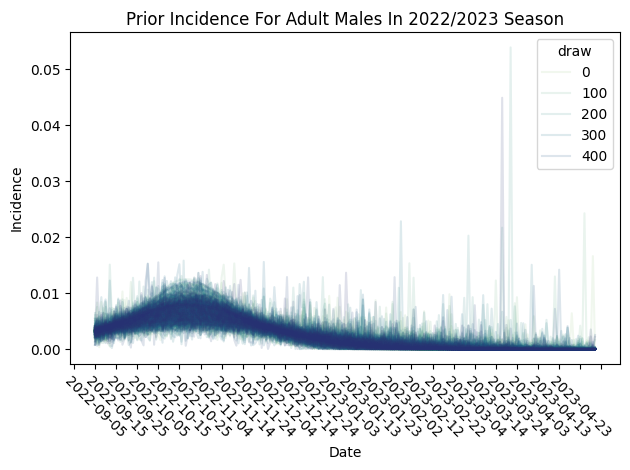

In [13]:
sns.lineplot(
    data=adult_male_df,
    x="season_2022_2023_dates",
    y="Incidence20222023SexMaleAgeAdult",
    hue="draw",
    palette="crest",
    alpha=0.15,
)
plt.xlabel("Date")
plt.ylabel("Incidence")
plt.title("Prior Incidence For Adult Males In 2022/2023 Season")

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.xticks(rotation=-45)
plt.tight_layout()
plt.show()

In [14]:
adult_male_df = adult_male_df.reset_index().sort_values(
    by=["season_2022_2023_dates", "draw"]
)
adult_male_df["Prevalence20222023SexMaleAgeAdult"] = adult_male_df.groupby("draw")[
    "Incidence20222023SexMaleAgeAdult"
].cumsum()

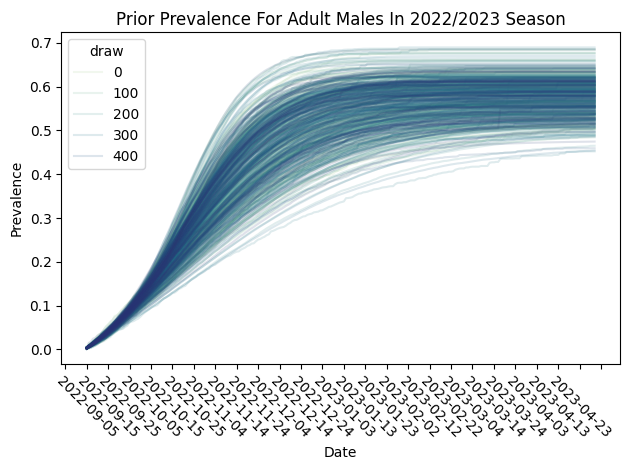

In [15]:
sns.lineplot(
    data=adult_male_df,
    x="season_2022_2023_dates",
    y="Prevalence20222023SexMaleAgeAdult",
    hue="draw",
    palette="crest",
    alpha=0.15,
)
plt.xlabel("Date")
plt.ylabel("Prevalence")
plt.title("Prior Prevalence For Adult Males In 2022/2023 Season")

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.xticks(rotation=-45)
plt.tight_layout()
plt.show()

In [16]:
# Manual generation of a sample data set from one of the prior distribution draws
draw = 10
coords = model.coordinates()
incidence_dfs = []
for label in coords["season_by_category"]:
    split_labels = label.split("_")
    prior_label = "".join(
        w.title() for w in label.replace("season", "incidence").split("_")
    )
    incidence_df = (
        prior.prior[prior_label]
        .sel(chain=0, draw=draw)
        .squeeze()
        .to_dataframe()
        .drop(columns=["chain", "draw"])
    )
    incidence_df[split_labels[0]] = f"{split_labels[1]}/{split_labels[2]}"
    incidence_df[split_labels[3]] = split_labels[4]
    incidence_df[split_labels[5]] = split_labels[6]
    for i in (0, 3, 5):
        incidence_df[split_labels[i]] = incidence_df[split_labels[i]].astype("string")
    incidence_df["date"] = pd.to_datetime(incidence_df.index.to_series())
    incidence_df = incidence_df.reset_index(drop=True)
    incidence_df = incidence_df.rename(columns={prior_label: "incidence"})
    incidence_dfs.append(incidence_df)
incidence_df = pd.concat(incidence_dfs)
incidence_df = incidence_df[["season", "date", "age", "sex", "incidence"]]
incidence_df = incidence_df.sort_values(["season", "date", "age", "sex"])
incidence_df

,season,date,age,sex,incidence
0,2022/2023,2022-09-05,adult,female,2.732415e-03
0,2022/2023,2022-09-05,adult,male,2.335180e-03
0,2022/2023,2022-09-05,senior,female,2.969011e-03
0,2022/2023,2022-09-05,senior,male,3.304090e-03
0,2022/2023,2022-09-05,youth,female,2.908418e-03
...,...,...,...,...,...
237,2023/2024,2024-04-28,adult,male,2.524119e-04
237,2023/2024,2024-04-28,senior,female,0.000000e+00
237,2023/2024,2024-04-28,senior,male,4.772762e-51
237,2023/2024,2024-04-28,youth,female,1.150737e-37


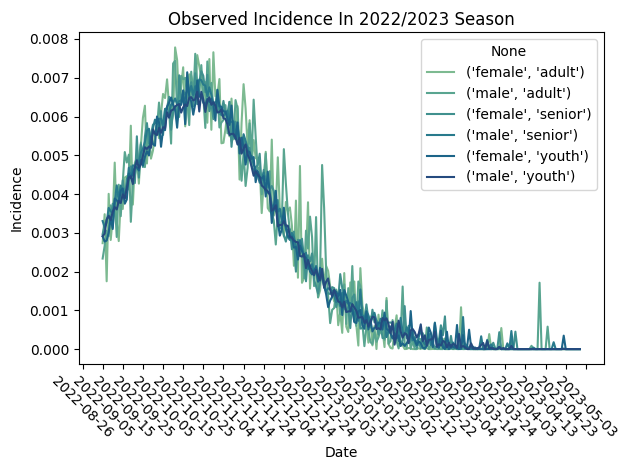

In [17]:
sns.lineplot(
    data=incidence_df[incidence_df["season"] == "2022/2023"],
    x="date",
    y="incidence",
    hue=incidence_df[incidence_df["season"] == "2022/2023"][["sex", "age"]].apply(
        tuple, axis=1
    ),
    palette="crest",
)
plt.xlabel("Date")
plt.ylabel("Incidence")
plt.title("Observed Incidence In 2022/2023 Season")

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.xticks(rotation=-45)
plt.tight_layout()
plt.show()

In [18]:
incidence_df["prevalence"] = (
    incidence_df.sort_values(["date", "season", "sex", "age"])
    .groupby(["season", "sex", "age"])["incidence"]
    .cumsum()
)
incidence_df

,season,date,age,sex,incidence,prevalence
0,2022/2023,2022-09-05,adult,female,2.732415e-03,0.002732
0,2022/2023,2022-09-05,adult,male,2.335180e-03,0.002969
0,2022/2023,2022-09-05,senior,female,2.969011e-03,0.002908
0,2022/2023,2022-09-05,senior,male,3.304090e-03,0.002335
0,2022/2023,2022-09-05,youth,female,2.908418e-03,0.003304
...,...,...,...,...,...,...
237,2023/2024,2024-04-28,adult,male,2.524119e-04,0.619059
237,2023/2024,2024-04-28,senior,female,0.000000e+00,0.600196
237,2023/2024,2024-04-28,senior,male,4.772762e-51,0.646186
237,2023/2024,2024-04-28,youth,female,1.150737e-37,0.640131


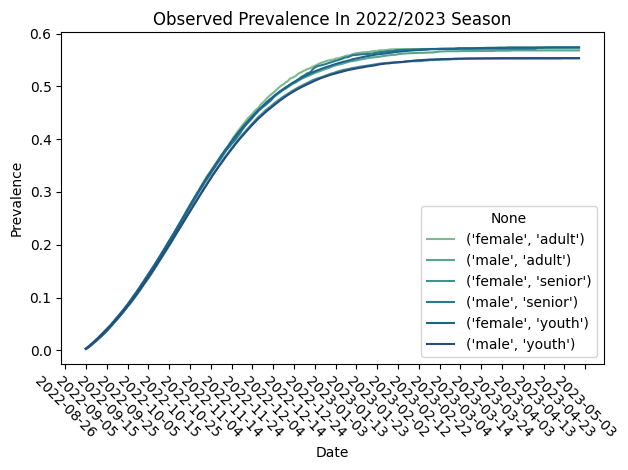

In [19]:
sns.lineplot(
    data=incidence_df[incidence_df["season"] == "2022/2023"],
    x="date",
    y="prevalence",
    hue=incidence_df[incidence_df["season"] == "2022/2023"][["sex", "age"]].apply(
        tuple, axis=1
    ),
    palette="crest",
)
plt.xlabel("Date")
plt.ylabel("Prevalence")
plt.title("Observed Prevalence In 2022/2023 Season")

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.xticks(rotation=-45)
plt.tight_layout()
plt.show()

In [20]:
observations = incidence_df.copy()
observations = observations.drop(columns=["prevalence"])
observations = (
    observations.groupby(
        ["season", "age", "sex", pd.Grouper(key="date", freq="W-SUN")]
    )["incidence"]
    .sum()
    .reset_index()
)
observations = observations.rename(columns={"date": "end_date", "incidence": "value"})
observations["start_date"] = observations["end_date"] - pd.Timedelta(days=6)
observations["type"] = "incidence"
observations = observations[
    ["season", "start_date", "end_date", "age", "sex", "type", "value"]
]
observations

,season,start_date,end_date,age,sex,type,value
0,2022/2023,2022-09-05,2022-09-11,adult,female,incidence,2.295724e-02
1,2022/2023,2022-09-12,2022-09-18,adult,female,incidence,2.655974e-02
2,2022/2023,2022-09-19,2022-09-25,adult,female,incidence,3.469831e-02
3,2022/2023,2022-09-26,2022-10-02,adult,female,incidence,3.821164e-02
4,2022/2023,2022-10-03,2022-10-09,adult,female,incidence,4.359717e-02
...,...,...,...,...,...,...,...
403,2023/2024,2024-03-25,2024-03-31,youth,male,incidence,3.734192e-04
404,2023/2024,2024-04-01,2024-04-07,youth,male,incidence,5.305981e-04
405,2023/2024,2024-04-08,2024-04-14,youth,male,incidence,3.524628e-06
406,2023/2024,2024-04-15,2024-04-21,youth,male,incidence,9.661910e-06


In [21]:
observations_model = model.add_observations(observations)
observations_model

In [22]:
observations_model.build(debug=True)

INFO: Using 68 date ranges for the uptake model.
INFO: Using 68 date ranges for the uptake model.
INFO: Using 408 observational date ranges for the uptake model.
INFO: Using 408 observational date ranges for the uptake model.
INFO: Added season 2022/2023 to the model with 238 days.
INFO: Added season 2022/2023 to the model with 238 days.
INFO: Added season 2023/2024 to the model with 238 days.
INFO: Added season 2023/2024 to the model with 238 days.
INFO: Added covariate MSeason to the model.
INFO: Added covariate MSeason to the model.
INFO: Added covariate MSex to the model.
INFO: Added covariate MSex to the model.
INFO: Added covariate MAge to the model.
INFO: Added covariate MAge to the model.
INFO: Added covariate RSeason to the model.
INFO: Added covariate RSeason to the model.
INFO: Added covariate SSeason to the model.
INFO: Added covariate SSeason to the model.
INFO: Added summed parameter MSeason20222023SexFemaleAgeYouth to the model.
INFO: Added summed parameter MSeason202220

In [23]:
trace = observations_model.sample(
    tune=1_000,
    draws=2_000,
    chains=2,
    cores=2,
)

Running window adaptation


There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
